### Logistic Regression

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize as op
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import PolynomialFeatures
# %matplotlib notebook

In [2]:
data = np.loadtxt("ex2data1.txt", delimiter=",")
m,n = data.shape
X = data[:,0:2]
XX = np.concatenate((np.ones((m, 1)), data[:, :-1]), axis=1)
Y = data[:,2]

In [3]:
def plotData(x,y, labels, x_y_lab):
    pos = x[y==1]
    neg = x[y==0]
    fig = plt.figure(figsize=(8,6), dpi=80 )
    plt.scatter(pos[:,0], pos[:,1], c="k", marker="+")
    plt.scatter(neg[:,0], neg[:,1], c ="y", marker="o")
    plt.xlabel(x_y_lab[0])
    plt.ylabel(x_y_lab[1])
    plt.legend(labels)

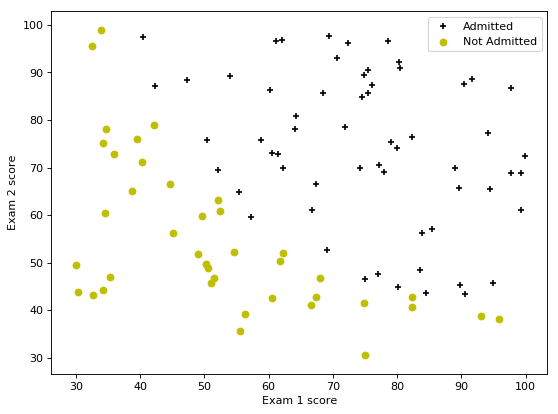

In [4]:
x_y_lab = ["Exam 1 score", "Exam 2 score"]
labels = ["Admitted", "Not Admitted"]
plotData(X,Y, labels, x_y_lab)

In [5]:
#sigmoid function for Logistic Regression
def sigmoid(x):
    g = (1)/(1+(np.exp(-x)))
    return g

In [7]:
def costFunction(theta,xx,y):
    theta = np.reshape(theta, (3,1))
    m = y.size
    J = 0
    h = sigmoid(xx.dot(theta)) # get predictions
    J = -(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))/m
    if np.isnan(J):
        J = np.inf
    return (J)

In [8]:
def Gradient(theta,xx,y):
    theta = np.reshape(theta, (3,1))
    y = np.c_[y]
    m = y.size
    h = sigmoid(xx.dot(theta))
    grad = (xx.T.dot(h-y))/m
    return np.ndarray.flatten(grad)

In [9]:
m,n= XX.shape
initial_theta = np.zeros((n,1),dtype=float)
Cost_J, gradient = costFunction(initial_theta,XX,Y), Gradient(initial_theta,XX,Y)
# gradient = Gradient(initial_theta,XX,Y)
print(Cost_J)
print(gradient)

[0.69314718]
[ -0.1        -12.00921659 -11.26284221]


In [10]:
a = np.array((-24, 0.2, 0.2,), dtype=float)
test_theta = np.reshape(a, (3,1))
test_J = costFunction(test_theta,XX,Y)
test_gradient = Gradient(test_theta,XX,Y)
print(test_J)
print(test_gradient)

[0.21833019]
[0.04290299 2.56623412 2.64679737]


### Scipy Optimization (Instead gradient Descent)

In [11]:
res = op.minimize(costFunction, initial_theta, args=(XX, Y), method=None, jac=Gradient, options={'maxiter': 400})

In [12]:
res

      fun: 0.2034977015895099
 hess_inv: array([[ 2.85339493e+03, -2.32908823e+01, -2.27416470e+01],
       [-2.32908823e+01,  2.04489131e-01,  1.72969525e-01],
       [-2.27416470e+01,  1.72969525e-01,  1.96170322e-01]])
      jac: array([-2.68557626e-09,  4.36433481e-07, -1.39671757e-06])
  message: 'Optimization terminated successfully.'
     nfev: 34
      nit: 25
     njev: 30
   status: 0
  success: True
        x: array([-25.16131634,   0.2062316 ,   0.20147143])

In [13]:
print("Cost(J) at theta using scipy minimized:"), res.fun
print("\ntheta minimized:"), res.x

Cost(J) at theta using scipy minimized:

theta minimized:


(None, array([-25.16131634,   0.2062316 ,   0.20147143]))

In [14]:
theta_min = np.reshape(res.x, (3,1))
cost_min = costFunction(theta_min, XX, Y)
cost_min

array([0.2034977])

In [15]:
def predict(theta, xx):
    theta = np.reshape(theta, (3,1))
    h = sigmoid(xx.dot(theta))
    threshold = 0.5
    p = []       
    for i in range(len(h)):
        if (h[i]>=threshold):
            p.append(1)   
        else:
            p.append(0)
    p = np.c_[p] #vector of predicted values (not list)
    return p

In [16]:
p = predict(theta_min, XX)
print('Train accuracy {}%'.format(100 * sum(p.ravel() == Y.ravel()) / p.size))

Train accuracy 89.0%


### Plot Decision Boundry

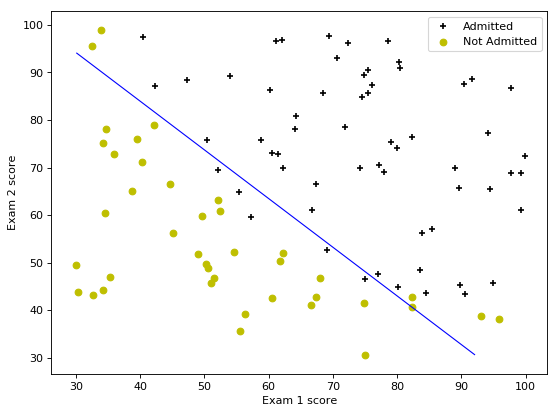

In [18]:
x1_min, x1_max = XX[:,1].min(), XX[:,1].max()
x2_min, x2_max= XX[:,2].min(), XX[:,2].max()
x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((x1.ravel().shape[0],1)), x1.ravel(), x2.ravel()].dot(theta_min))
h = np.reshape(h, (x1.shape[0],x1.shape[1]))
plotData(X,Y, labels, x_y_lab)
plt.contour(x1, x2, h, [0.5], linewidths=1, colors='b')

### Regularized Logistic Regression

In [19]:
data1 = np.loadtxt("ex2data2.txt", delimiter=',')

In [20]:
m, n= data1.shape
XX1 = np.concatenate((np.ones((m, 1)), data1[:, :-1]), axis=1)
X1 = data1[:,0:2]
Y1 = data1[:, 2]

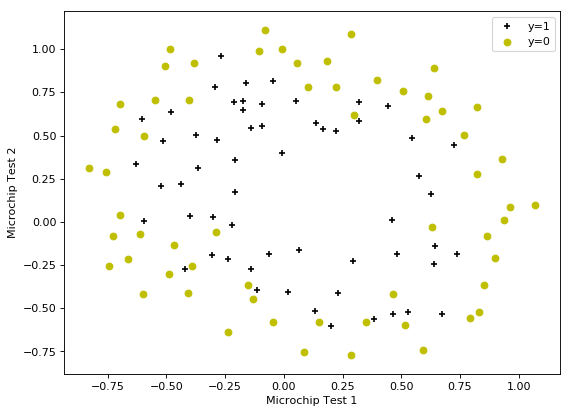

In [21]:
x_y_lab = ["Microchip Test 1", "Microchip Test 2"]
labels = ["y=1", "y=0"]
plotData(X1,Y1, labels, x_y_lab)

In [22]:
def mapFeature(x1,x2, degree):
    degree = 6
    featuremap = []
    for i in range(degree):
        for j in range(0,i):
            featuremap.append(np.power(x1,i-j)*(np.power(x2, j)))
    return featuremap

In [23]:
poly = PolynomialFeatures(6)
XX1 = poly.fit_transform(X1)
m, n = XX1.shape

In [24]:
def costFunctionReg(theta, xx , y , l): #l is lambda here 
    m, n = xx.shape
    theta = np.reshape(theta, (n,1))
    m = y.size
    y = np.c_[y]
    J = 0
    h = sigmoid(xx.dot(theta))
    regterm = []
    for i in range(len(theta)-1):
        regterm.append(theta[i+1]**2)
    reg_f = (np.sum(regterm))*l/(2*m)
    J = -(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))/m + reg_f
    if np.isnan(J[0]):
        J[0] = np.inf
    return (J[0])

In [25]:
def GradientReg(theta, xx , y , l):
    m, n = xx.shape
    theta = np.reshape(theta, (n,1))
    m = y.size
    y = np.c_[y]
    h = sigmoid(xx.dot(theta))
    grad = np.zeros((n,1))
    grad = (xx.T.dot(h-y)+float(l)*(theta))/m
    return(np.ndarray.flatten(grad))

In [26]:
initial_theta = np.zeros((n,1), dtype=float)
cost_J  = costFunctionReg(initial_theta, XX1 , Y1 , 1)
gradient = GradientReg(initial_theta, XX1 , Y1 , 1)
cost_J 

array([0.69314718])

In [28]:
res1 = op.minimize(costFunctionReg, initial_theta, args=(XX1, Y1, 1), jac = GradientReg, method=None,options={'maxiter': 400})


In [29]:
cost_reg = res1.fun
theta_reg = res1.x

In [30]:
cost_reg

0.5300109345445478

In [31]:
theta_reg

array([ 1.13905468,  0.63561419,  1.14968144, -1.8671565 , -0.93002944,
       -1.17283912,  0.12525871, -0.37879674, -0.37243299, -0.19872063,
       -1.43486075, -0.11446387, -0.57707841, -0.29370381, -1.16788635,
       -0.25414287, -0.23001402, -0.06942998, -0.27019065, -0.30109071,
       -0.55955345, -1.06378139, -0.01754239, -0.28333104, -0.01385566,
       -0.31456354, -0.15796289, -1.02391622])

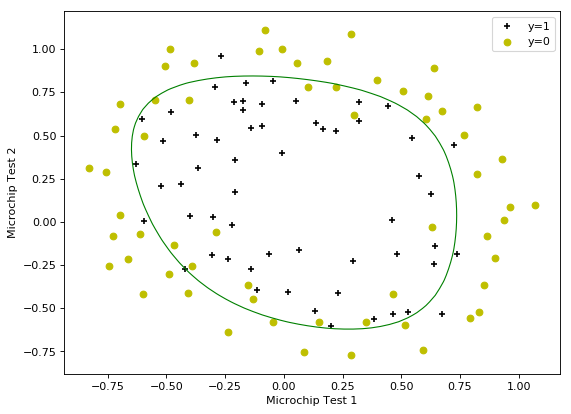

In [32]:
x1_min, x1_max = XX1[:,1].min(), XX1[:,1].max()
x2_min, x2_max= XX1[:,2].min(), XX1[:,2].max()
x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(poly.fit_transform(np.c_[x1.ravel(), x2.ravel()]).dot(theta_reg))
h = np.reshape(h, (x1.shape[0],x1.shape[1]))
x_y_lab = ["Microchip Test 1", "Microchip Test 2"]
labels = ["y=1", "y=0"]
plotData(X1,Y1, labels, x_y_lab)
plt.contour(x1, x2, h, [0.5], linewidths=1, colors='g')